In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

In [5]:
data = pd.read_csv('agaricus-lepiota.csv')
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


 надо перевести данные в численный вид, правильнее было бы использовать one hot encoder, но чтоб не генерировать много новых признаков буду использовать labelencoder, так как лабараторная работа расчитана больше на изучении алгоритма чем на обработку данных

In [6]:
from sklearn.preprocessing import LabelEncoder
for col in data.columns:
    labelencoder = LabelEncoder()
    data[col] = labelencoder.fit_transform(data[col])

In [7]:
X = data
X = X.rename(columns={'u':'target'})
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,target
4634,1,5,3,9,0,2,1,0,0,7,...,1,0,6,0,2,1,2,1,5,0
6652,1,5,3,2,0,2,1,0,1,0,...,2,6,7,0,2,1,0,7,4,2
6140,1,2,3,2,0,8,1,0,1,0,...,2,6,7,0,2,1,0,7,4,2
7151,1,5,2,2,0,7,1,0,1,0,...,1,7,7,0,2,1,0,7,4,0
438,0,5,3,4,1,0,1,0,0,7,...,3,7,7,0,2,1,4,3,5,4


In [65]:
X_train, X_test = train_test_split(data, test_size=0.2)

In [18]:
def freq(sample, cl):
    return (sample.u == cl).sum()

def info(sample):
    summ = 0
    class_values = sample.u.unique()
    for class_value in class_values:
        frequency = freq(sample, class_value) / sample.shape[0]
        summ += frequency * log(frequency, 2)
    return (-1) * summ


In [19]:
def infox(sample, split_field):
    summ = 0
    n = sample.shape[0]
    field_values = sample[split_field].unique()
    for field_value in field_values:
        same_field_value_subsample = sample[sample[split_field] == field_value]
        summ += same_field_value_subsample.shape[0] * info(same_field_value_subsample) / n
    return summ

def splitinfox(sample, split_field):
    summ = 0
    n = sample.shape[0]
    field_values = sample[split_field].unique()
    for field_value in field_values:
        same_field_value_subsample = sample[sample[split_field] == field_value]
        frequency = same_field_value_subsample.shape[0] / n
        summ += frequency * log(frequency, 2)
    return (-1) * summ

In [20]:
def gain_ratio(sample, split_field):
    return (info(sample) - infox(sample, split_field)) / splitinfox(sample, split_field)

In [21]:
class Model:
    counter = 0

    def __init__(self, sample):
        self.id = Model.counter
        Model.counter += 1
        sample_fields = sample.drop(columns='u').columns
        sample_fields_gains = pd.Series([
            gain_ratio(sample, sample_field) * int(len(sample[sample_field].unique()) != 1)
            for sample_field in sample_fields]).fillna(0)
        self.subtrees = {}
        self.most_frequent_target = sample.u.mode()[0]
        self.split_field = None
        self.leaf_class = sample.u.unique()
        if not any(sample_fields_gains) or len(sample.u.unique()) == 1:
            self.leaf = True
            return
        self.split_field = sample_fields[np.argmax(sample_fields_gains)]
        self.leaf = False
        for split_field_value in sample[self.split_field].unique():
            self.subtrees[split_field_value] = Model(sample[sample[self.split_field] == split_field_value].drop(columns=self.split_field))
  
    def eval_one(self, sample_item):
        if not self.leaf:
            sep_val = sample_item[self.split_field]
            if sep_val in self.subtrees:
                return self.subtrees[sep_val].eval_one(sample_item)
            return self.most_frequent_target
        final_class = self.leaf_class
        assert len(final_class) != 0
        if len(final_class) == 1:
            return final_class[0]
        return self.most_frequent_target
  

In [24]:
results = []
m_pos = set()
pos = set()
m_neg = set()
neg = set()

tree = Model(X_train)

In [25]:
#собираем результаты
for i in range(X_test.shape[0]):
    model_estimation = tree.eval_one(test.drop(columns='u').iloc[i])
    if test.iloc[i].u:
        pos.add(i)
    else:
        neg.add(i)
    results.append(model_estimation)
    if model_estimation:
        m_pos.add(i)
    else:
        m_neg.add(i)

In [29]:
#считаем accuracy
(np.array(results) == np.array(test.u.tolist())).astype(int).sum()\
     / len(results)

0.6676923076923077

In [67]:
cl = 0

 
tst = np.array(X_test.u == 0).astype(int)
res = (np.array(results) == 0).astype(int)

In [68]:
FPR, TPR, thresholds = roc_curve(tst, res)

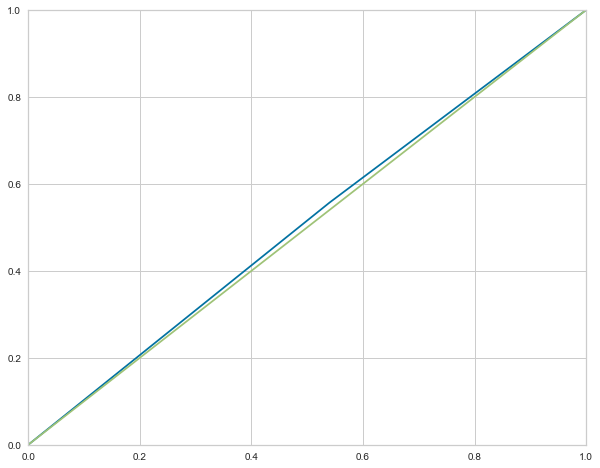

In [70]:
plt.figure(figsize=(10, 8))

plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()